<a href="https://colab.research.google.com/github/marco-scatassi/TLDR_text_summarization/blob/main/1_text_summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library Import - General


In [1]:
import pandas as pd
import numpy as np

# Data Loading


In [2]:
train = pd.read_json('/content/train_lemmatized.json', orient="records", lines=True)
train_lemmatized = train['document_lemmatized']
train.head(1)

,id,document,summary,ext_labels,rg_labels,document_normalized,document_tokenized,document_stopwords,document_lemmatized
0,train-TLDR_RS_2019-07-25907.json,"[hey y' all , i 've been a lurker in this comm...",i 'm publishing betas of some stuff i 've been...,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.040456223300000003, 0.022386650100000002, 0...",[hey y all i have been a lurked in this commun...,"[[hey, y, all, i, have, been, a, lurked, in, t...","[[hey, lurked, community, sons, time, contribu...","[[hey, lurked, community, son, time, contribut..."


In [3]:
val = pd.read_json('/content/val_lemmatized.json', orient="records", lines=True)
val_lemmatized = val['document_lemmatized']
val.head(1)

,id,document,summary,ext_labels,rg_labels,document_normalized,document_tokenized,document_stopwords,document_lemmatized
0,train-TLDR_RS_2019-02-45730.json,[so i just had the thought of what if people c...,name a new eve every 2 - 5 generations so that...,"[0, 0, 1, 0, 0]","[0.14523170130000002, 0.0821840568, 0.47712410...",[so i just had the thought of what if people c...,"[[so, i, just, had, the, thought, of, what, if...","[[thought, people, could, name, children, even...","[[thought, people, could, name, child, even, c..."


In [4]:
test = pd.read_json('/content/test_lemmatized.json', orient="records", lines=True)
test_lemmatized = test['document_lemmatized']
test.head(1)

,id,document,summary,ext_labels,rg_labels,document_normalized,document_tokenized,document_stopwords,document_lemmatized
0,train-TLDR_RS_2019-02-45730.json,[so i just had the thought of what if people c...,name a new eve every 2 - 5 generations so that...,"[0, 0, 1, 0, 0]","[0.14523170130000002, 0.0821840568, 0.47712410...",[so i just had the thought of what if people c...,"[[so, i, just, had, the, thought, of, what, if...","[[thought, people, could, name, children, even...","[[thought, people, could, name, child, even, c..."


# POS tagging

## Library import

In [5]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')
nltk.download('universal_tagset')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

Serve per estrarre il solo tag dalla coppia (word,tag) restituita dal *nltk.tag.pos_tag_sents*

In [6]:
def extract_tags(document_tags: list):
  doc_tags = pd.Series(document_tags)
  doc_tags = doc_tags.apply(lambda subList: pd.Series(subList))
  doc_tags = doc_tags.applymap(lambda wordTagTuple: wordTagTuple[1] if type(wordTagTuple)==tuple else '')
  return doc_tags.values

Lavora direttamente su una lista di frasi (ovvero il documento), in questo modo èpiù efficiente

In [7]:
def POS_tagging(document: list, tagset:str = 'universal', lang:str='eng'):
  POS_tags = nltk.tag.pos_tag_sents(document, tagset=tagset, lang=lang)
  POS_tags = extract_tags(POS_tags)
  return POS_tags

In [27]:
train['POS_tag'] = train_lemmatized.apply(POS_tagging)
val['POS_tag'] = val_lemmatized.apply(POS_tagging)
test['POS_tag'] = test_lemmatized.apply(POS_tagging)

<ipython-input-6-30dcbc3a4af6>:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  doc_tags = doc_tags.apply(lambda subList: pd.Series(subList))


# Text Summarization

## Library import

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import HistGradientBoostingClassifier

## Features definition


In [33]:
def sentence_relative_positions(sentence: list, document: list):
  doc = pd.Series(document)
  sentence_index = doc[doc.apply(lambda x: x==sentence)].index.to_list()[0]
  if len(doc)-1 == 0:
    return 0
  else:
    relative_index = sentence_index/(len(doc)-1)
    return relative_index

396

In [57]:
def word_in_sentence_relative(sentence: list, document:list):
  doc = pd.Series(document)
  word_in_sentence = len(sentence)
  word_in_document = doc.apply(len).sum()
  return word_in_sentence/word_in_document

In [12]:
def POS_tag_ratio(sentence: list, tag_name: str, document: list, document_tags: list):
  doc = pd.Series(document)

  sentence_index = document[document.apply(lambda x: x==sentence)].index.to_list()[0]
  tags = document_tags[sentence_index]

  sentence_length = len(sentence)

  if sentence_length == 0:
    return 0
  else:
    return sum(tags==tag_name)/sentence_length

In [13]:
def TF_ISF_and_Sentence_similarity_score_n_gram(document: list, n: int=1):
  doc = pd.Series(document)
  doc = doc.apply(lambda wordList: ' '.join(wordList))
  
  vectorizer = TfidfVectorizer(ngram_range=(n,n))
  X = vectorizer.fit_transform(doc)

  tf_isf_absolute = X.sum(axis=1)
  tf_isf_relative = tf_isf_absolute/max(tf_isf_absolute)

  sentence_similarity_absolute = np.array(list(map(lambda x: x.sum(), cosine_similarity(X))))
  sentence_similarity_relative = sentence_similarity_absolute/len(doc)

  return (np.array(tf_isf_relative).flatten(), sentence_similarity_relative)

## Dataset generation

In [351]:
def sentence_feature_matrix(document_data: pd.Series):
  doc = pd.Series(document_data['document_lemmatized'])
  doc_tag = document_data['POS_tag']
  
  s = pd.DataFrame()

  s['sentence_relative_positions'] = doc.apply(sentence_relative_positions, document = doc)
  s['word_in_sentence_relative'] = doc.apply(word_in_sentence_relative, document = doc)

  for tag_name in ['NOUN','VERB','ADJ', 'ADV']:
    s['POS_tag_ratio_'+tag_name] = doc.apply(POS_tag_ratio, tag_name = tag_name, document = doc, document_tags = doc_tag)
  
  for n in [1]:
    (s['tf_isf_'+str(n)+'_gram'], s['sentence_similarity_'+str(n)+'_gram']) = TF_ISF_and_Sentence_similarity_score_n_gram(doc, n)

  s['ext_labels'] = document_data['ext_labels']

  return s

In [352]:
train_lem_tag = train[['document_lemmatized','POS_tag', 'ext_labels']]
val_lem_tag = val[['document_lemmatized','POS_tag', 'ext_labels']]
test_lem_tag = test[['document_lemmatized','POS_tag', 'ext_labels']]

In [353]:
%time dfs = train_lem_tag.apply(sentence_feature_matrix, axis=1)
train_summarization = pd.concat(list(dfs), ignore_index=True)

CPU times: user 4.14 s, sys: 40.4 ms, total: 4.18 s
Wall time: 4.2 s


In [354]:
%time dfs = val_lem_tag.apply(sentence_feature_matrix, axis=1)
val_summarization = pd.concat(list(dfs), ignore_index=True)

CPU times: user 4.51 s, sys: 48.4 ms, total: 4.56 s
Wall time: 4.56 s


In [355]:
%time test_summarization_splitted = test_lem_tag.apply(sentence_feature_matrix, axis=1)
test_summarization = pd.concat(list(test_summarization_splitted), ignore_index=True)

CPU times: user 4.34 s, sys: 21.9 ms, total: 4.36 s
Wall time: 4.39 s


### Dataset exploration

#### Library import

In [356]:
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from numpy.linalg import norm, pinv, matrix_rank
import random
from scipy.linalg import svd
from sklearn.decomposition import TruncatedSVD
from numpy.linalg import matrix_rank

#### Exploration

In [357]:
dataset_summarization = pd.concat([train_summarization,val_summarization,test_summarization])

In [358]:
features = dataset_summarization.columns.delete(-1)

In [359]:
dataset_summarization['ext_labels'].value_counts()

0    4237
1     498
Name: ext_labels, dtype: int64

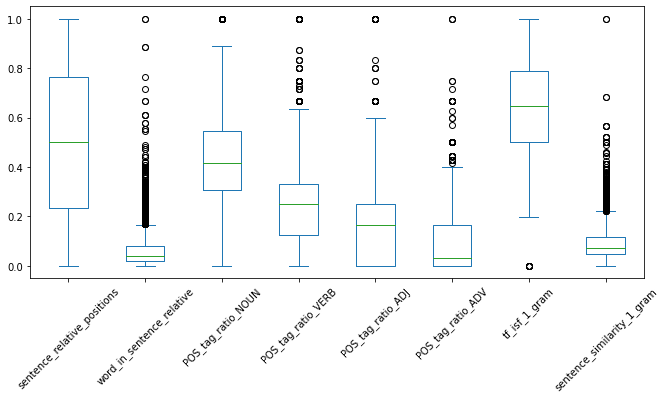

In [360]:
dataset_summarization[features].plot.box(figsize=(11,5), rot=45)

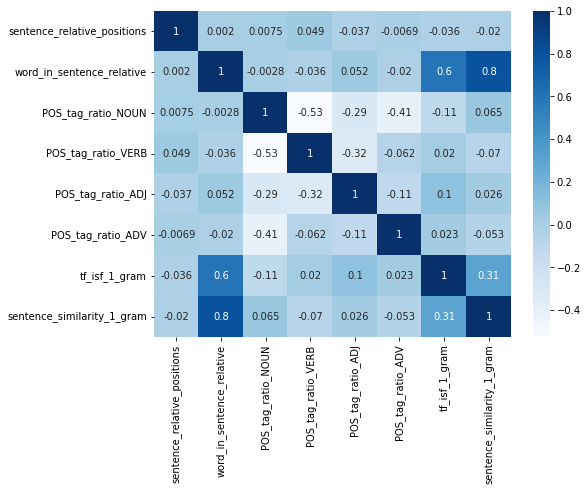

In [361]:
f, ax = plt.subplots(figsize=(8, 6))
corr = dataset_summarization[features].corr()
sns.heatmap(corr, cmap="Blues", annot=True)

### Undersampling

In [362]:
def ColumnSelect(A, k, c, v):
    # {
    # Input
    # - A: una matrice m x n.
    # - k: un parametro di rango k.
    # - c: numero di colonne che vogliamo selezionare da A.
    # - v: matrice n x k dei primi k vettori singolari destri di A.
    # Output
    # - C: matrice m x c' con c' colonne da A, c' <= c.
    # }

    random.seed(30)

    m,n = A.shape
    #------- Calcolo del normalized leverage scores di eqn. 3 di [1]. ---------
    pi = []
    for j in range(n):
        pi.append((norm(v[j,:])**2) / k )
        
    #--------------------------selezione colonne ------------------------------
    indexA = []
    for j in range(n):
        # la j-esima colonna di A è selezionata con probabilità prob_j.
        prob_j = min([1,c*pi[j]])   #trova il minimo tra 1 e c*pi(j)

        if prob_j==1: # se prob_j=1 seleziona la j-esima colonna di A
            indexA.append(j)
        elif prob_j > random.random():  # se prob_j<1, genera un numero casuale in [0,1]
            indexA.append(j) # poi se prob_j > rand, seleziona la j-esima colonna di A

    # Al termine indexA conterrà gli indici delle colonne selezionate da A
    C = A[:, indexA]
    return C, indexA

In [312]:
def CUR(A, k, c, r):
    # {
    # Input:
    # - A: matrice m x n.
    # - k: parametro di rango, con k << min(m,n).
    # - c: numero di colonne che vogliamo selezionare da A.
    # - r: numero di righe che vogliamo slezionare da A.
    # Ouput:
    # - C: matrice m x c' con c' colonne da A, c' <= c.)
    # - R: matrice r' x n con r' righe da A, r' <= r.
    # - U_pi: matrice c' x r'.
    # }

    # calcolo dei primi k vettori singolari destri di A and A'
    U, s, Vt = svd(A, full_matrices = False)
    V = Vt.transpose() 
    Vk = V[:,:k]
    Uk = U[:,:k] 

    #-------------------------- Algoritmo CUR ---------------------------------
    C, indexAc = ColumnSelect(A, k, c, Vk)             # Sceglie c' colonne da A.
    R, indexAr = ColumnSelect(A.transpose(), k, r, Uk) #  Sceglie r' righe da A.
    R=R.transpose()
    U=A[indexAr, :][:,indexAc]  #costruisce U come in teorema [2.1.1]
    U_pi=pinv(U);               #determina la pseudoinversa di U
    return C, U_pi, R, indexAr, indexAc

In [294]:
def CUR_undersampling(training_dataset: pd.DataFrame, ratio: float=0.5, analysis: bool=True):
  A = training_dataset[features]
  A_0 = A[training_dataset['ext_labels']==0]
  A_1 = A[training_dataset['ext_labels']==1]

  k = min(A_0.shape[1], int(A_0.shape[0]*ratio))
  C, U_pi, R, indexAr, indexAc = CUR(np.matrix(A_0), k, A_0.shape[1], int(A_0.shape[0]*ratio))

  A_undersampled = A_1.append(A_0.iloc[indexAr,:])
  A_undersampled['ext_labels'] = training_dataset['ext_labels'].iloc[A_undersampled.index]

  if analysis:
    A_0_reconstructed = np.round(np.matmul((np.matmul(C, U_pi)),R),5)
    error = norm(A_0-A_0_reconstructed)/(norm(A_0))
    print('reconstruction error',error)

    print('Summary sentence proportion in original dataset', np.round(len(A_1)/(len(A)),4))
    print('Summary sentence proportion in the reduced dataset', np.round(len(A_1)/(len(A_undersampled)),3))

  return A_undersampled

## Machine learning model

In [363]:
train_summarization_undersampled = CUR_undersampling(train_summarization)

X_train = train_summarization_undersampled[features]
y_train = train_summarization_undersampled['ext_labels']

reconstruction error 6.10636481024403e-06
Summary sentence proportion in original dataset 0.1076
Summary sentence proportion in the reduced dataset 0.217


### Training

In [364]:
model = HistGradientBoostingClassifier()
model.fit(X_train,y_train)

HistGradientBoostingClassifier()

In [365]:
X_test = test_summarization[test_summarization.columns.delete(-1)]
y_test = test_summarization['ext_labels']

In [366]:
sum_ = 0
p = model.predict(X_test)
for i in range(len(y_test)):
  if p[i] == y_test[i] and y_test[i] == 1:
    sum_+=1
sum_/len(y_test.where(y_test==1).dropna())

0.16666666666666666

In [367]:
train_summarization.shape

(1505, 9)